In [1]:
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
import deepdish as dd
from brian2.only import *
import brian2genn

# for the IDE:
import numpy_ as np
import spatial, model, inputs, readout

from util import concatenate
np.concatenate = concatenate
from spike_utils import iterspikes


rng = np.random.default_rng()
set_device('genn', directory='GPU0')


N = 1000
inhibitory_ratio = .2
params = {
    # Simulation
    'dt': 1*ms,
    
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    'voltage_init': 'v_rest',
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # # Stochasticity
    # 'tau_noise': 10*msecond,
    # 'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    'weight_distribution': 'singular',
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': 1,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 50,
    'w_exc_mean': 1,

    # Stimulus
    'N_stimuli': 5,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 5,
    'sequence_count': 100,
    'fully_random_msc': True,
    'fully_random_oddball': True
}


N_networks = 50
ISIs = (100, 200, 300, 500, 1000, 2000)
pairings=(('A','B'), ('C','E'))

res = dd.io.load('isi1_idx_individual.h5')

INFO       The following preferences have been changed for Brian2GeNN, reset them manually if you use a different device later in the same script: codegen.loop_invariant_optimisations, core.network.default_schedule [brian2.devices.genn]


In [3]:
ddi, ai = res['ddi'], res['ai']

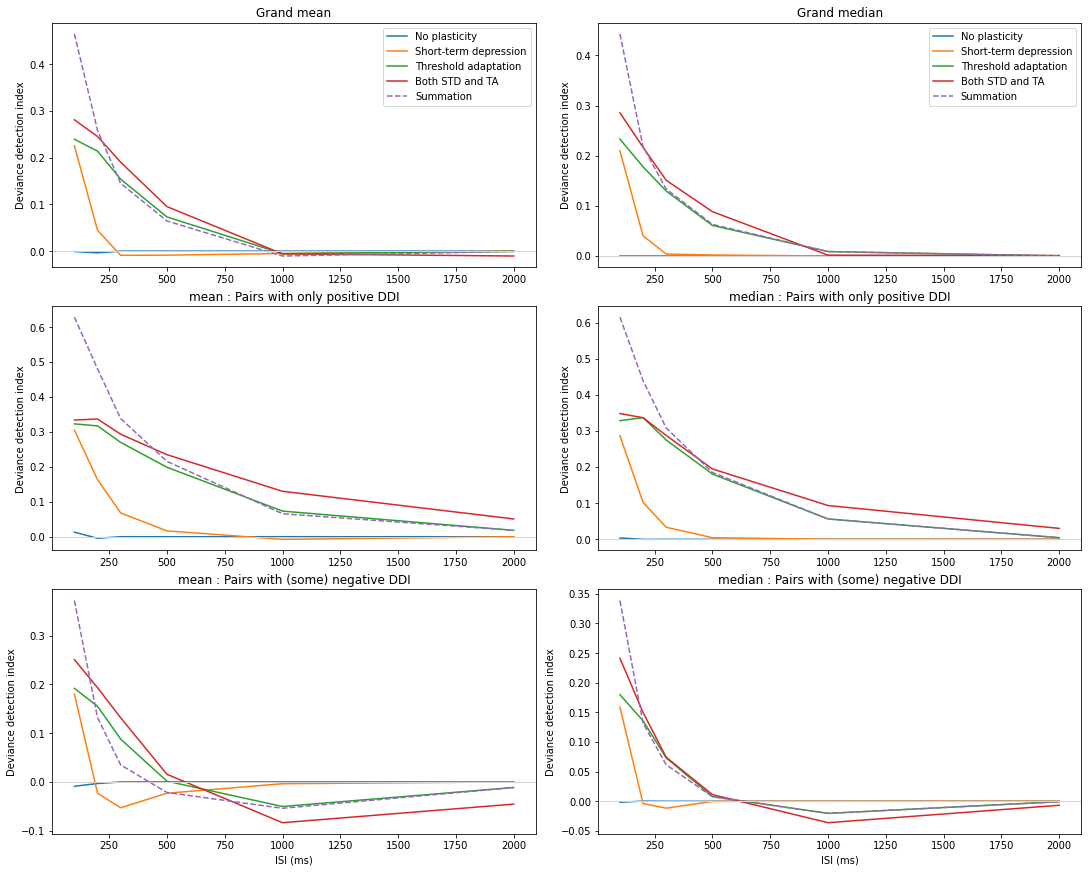

In [4]:
fig, axs = plt.subplots(3, 2, figsize=(15,12), constrained_layout=True)
for ax, fun, flabel in zip(axs.T, (np.mean, np.median), ('mean', 'median')):
    ax[0].plot(ISIs, fun(ddi[:, 0, 0].reshape(len(ISIs),-1), 1), label='No plasticity')
    ax[0].plot(ISIs, fun(ddi[:, 1, 0].reshape(len(ISIs),-1), 1), label='Short-term depression')
    ax[0].plot(ISIs, fun(ddi[:, 0, 1].reshape(len(ISIs),-1), 1), label='Threshold adaptation')
    ax[0].plot(ISIs, fun(ddi[:, 1, 1].reshape(len(ISIs),-1), 1), label='Both STD and TA')
    ax[0].plot(ISIs, fun(ddi[:, 0, 1].reshape(len(ISIs),-1), 1) + fun(ddi[:, 1, 0].reshape(len(ISIs),-1), 1), '--', label='Summation')
    ax[0].set_title(f'Grand {flabel}')

    mask = (ddi[:, 1, 1].reshape(len(ISIs), -1) <= 0).sum(0) == 0

    ax[1].plot(ISIs, fun(ddi[:, 0, 0].reshape(len(ISIs),-1)[:, mask], 1), label='No plasticity')
    ax[1].plot(ISIs, fun(ddi[:, 1, 0].reshape(len(ISIs),-1)[:, mask], 1), label='Short-term depression')
    ax[1].plot(ISIs, fun(ddi[:, 0, 1].reshape(len(ISIs),-1)[:, mask], 1), label='Threshold adaptation')
    ax[1].plot(ISIs, fun(ddi[:, 1, 1].reshape(len(ISIs),-1)[:, mask], 1), label='Both STD and TA')
    ax[1].plot(ISIs, fun(ddi[:, 0, 1].reshape(len(ISIs),-1)[:, mask], 1) + fun(ddi[:, 1, 0].reshape(len(ISIs),-1)[:, mask], 1), '--', label='Summation')
    ax[1].set_title(f'{flabel} : Pairs with only positive DDI')

    ax[2].plot(ISIs, fun(ddi[:, 0, 0].reshape(len(ISIs),-1)[:, ~mask], 1), label='No plasticity')
    ax[2].plot(ISIs, fun(ddi[:, 1, 0].reshape(len(ISIs),-1)[:, ~mask], 1), label='Short-term depression')
    ax[2].plot(ISIs, fun(ddi[:, 0, 1].reshape(len(ISIs),-1)[:, ~mask], 1), label='Threshold adaptation')
    ax[2].plot(ISIs, fun(ddi[:, 1, 1].reshape(len(ISIs),-1)[:, ~mask], 1), label='Both STD and TA')
    ax[2].plot(ISIs, fun(ddi[:, 0, 1].reshape(len(ISIs),-1)[:, ~mask], 1) + fun(ddi[:, 1, 0].reshape(len(ISIs),-1)[:, ~mask], 1), '--', label='Summation')
    ax[2].set_title(f'{flabel} : Pairs with (some) negative DDI')

    for a in ax:
        a.axhline(0, color='lightgrey', lw=1)
        a.set_ylabel(f'Deviance detection index')
    ax[-1].set_xlabel('ISI (ms)')
    ax[0].legend()